In [36]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.covariance import GraphicalLasso
from tqdm import tqdm
import pickle


# Sample data
lambdas = np.linspace(0, 0.4, 50)  # These are just sample k-values, replace with yours.
avg_edges = np.random.randn(50) + np.linspace(5000, 1000, 50)  # Replace with your average number of edges.

# Define a linear function for curve fitting
def linear_func(x, a, b):
    return a * x + b

def fit_lines_and_get_error(index, lambdas, edge_counts_dict):
    # Convert dictionary values to a list and then slice
    edge_counts_list = list(edge_counts_dict.values())

    left_data = lambdas[:index]
    right_data = lambdas[index+1:]

    if len(left_data) < 2 or len(right_data) < 2:
        return np.inf
    
    # Fit lines to the left and right of current index
    params_left, _ = curve_fit(linear_func, left_data, edge_counts_list[:index])
    params_right, _ = curve_fit(linear_func, right_data, edge_counts_list[index+1:])
    
    # Calculate fit errors
    error_left = np.sum((linear_func(left_data, *params_left) - edge_counts_list[:index]) ** 2)
    error_right = np.sum((linear_func(right_data, *params_right) - edge_counts_list[index+1:]) ** 2)
    
    return error_left + error_right, 

In [26]:
# Synthetic data and graphical model fitting

def count_edges(precision_matrix):
    """Count the number of non-zero off-diagonal entries (edges) in the precision matrix."""
    upper_triangle = np.triu(precision_matrix, k=1)
    return np.sum(upper_triangle != 0)

def fit_penalized_ggm(data, penalty_values):
    """
    Fit a penalized Gaussian graphical model (GGM) for a range of penalty values.
    
    Parameters:
    - data: Observed data. Shape (n_samples, n_features).
    - penalty_values: List of penalty values to fit the model.
    
    Returns:
    A dictionary with penalty values as keys and corresponding precision matrices as values.
    """
    # Calculate the empirical covariance matrix
    emp_cov = np.cov(data, rowvar=False)
    
    models = {}
    edge_counts = {}
    for penalty in tqdm(penalty_values):
        model = GraphicalLasso(alpha=penalty, max_iter=1000)
        model.fit(data)
        models[penalty] = model.precision_
        edge_counts[penalty] = count_edges(model.precision_)
        
    return models, edge_counts

# # Test the function with a small random data
# np.random.seed(0)
# data = np.random.randn(100, 100)
penalty_values = np.linspace(0.01, 0.4, 80)
# models, edge_counts = fit_penalized_ggm(data, penalty_values)

# # save edge counts to pkl file
# with open('edge_counts.pkl', 'wb') as f:
#     pickle.dump(edge_counts, f)


100%|██████████| 80/80 [00:20<00:00,  3.86it/s]


Found knee-point at k = 0.13835443037974685


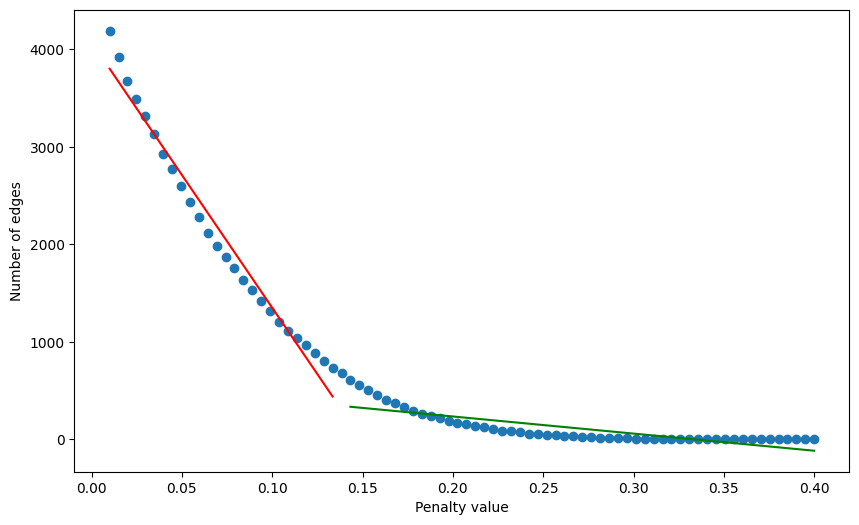

In [53]:
# import pickle file
with open('edge_counts.pkl', 'rb') as f:
    edge_counts = pickle.load(f)

# Calculate the total fit error for each k_value and find the 'knee-point'
errors = [fit_lines_and_get_error(i,penalty_values,edge_counts) for i in range(len(penalty_values))]
knee_point_index = np.argmin(errors)
knee_point = penalty_values[knee_point_index]

print("Found knee-point at k =", knee_point)

edge_counts_list = list(edge_counts.values())

# fit curves again around optimal knee-point for plotting
left_data = penalty_values[:knee_point_index]
right_data = penalty_values[knee_point_index+1:]
params_left, _ = curve_fit(linear_func, left_data, edge_counts_list[:knee_point_index])
params_right, _ = curve_fit(linear_func, right_data, edge_counts_list[knee_point_index+1:])
    

# plot the fitted curves to the left and right of the knee point
plt.figure(figsize=(10, 6))
plt.scatter(penalty_values, edge_counts.values())
plt.plot(penalty_values[:knee_point_index], linear_func(penalty_values[:knee_point_index], *params_left), color="red")
plt.plot(penalty_values[knee_point_index+1:], linear_func(penalty_values[knee_point_index+1:], *params_right), color="green")
plt.xlabel("Penalty value")
plt.ylabel("Number of edges")
plt.show()